<a href="https://colab.research.google.com/github/ran4erep/Stable-Colab/blob/main/Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Видео-инструкция](https://www.youtube.com/embed/VQ3YvX0-9wQ?si=19q0p3cpUpul8lVl)

[Ответы на часто задаваемые вопросы и разъяснения по поводу использования LoRA](https://www.youtube.com/embed/-ZI4TH8fjgM?si=QEGKbNAYzPee5RVE)

In [ ]:
# @title Установка Stable Diffusion и подключение Google Drive: { vertical-output: true, form-width: "10%", display-mode: "form" }
# @markdown Хотите исользовать Google Drive?
use_gdrive = False # @param {type:"boolean"}
# @markdown

import os
import torch
from google.colab import files
from PIL import Image
import io
import numpy as np
from datetime import date
from datetime import datetime
from IPython.display import clear_output
from IPython.display import display, update_display

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/gdrive')
  print("GDrive sucessfully mounted to /content/gdrive")
  # Создаём папку в Google Drive, если её нет
  if not os.path.exists("/content/gdrive/MyDrive/SDOutput"):
    os.makedirs("/content/gdrive/MyDrive/SDOutput", exist_ok=True)
    print("Успешно создана папка /content/gdrive/MyDrive/SDOutput")

!pip install diffusers["torch"] transformers
!pip install accelerate
#!pip install git+https://github.com/huggingface/diffusers
!pip install compel --upgrade

from diffusers import AutoPipelineForText2Image, AutoPipelineForImage2Image, AutoPipelineForInpainting
from diffusers import (
    DDPMScheduler,
    DDIMScheduler,
    PNDMScheduler,
    LMSDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    DPMSolverMultistepScheduler,
)
from diffusers.utils import make_image_grid, load_image
from compel import Compel, ReturnedEmbeddingsType
clear_output()
print("Установка завершена :)")

In [ ]:
# @title Подготовка Stable Diffusion: { vertical-output: true, form-width: "10%", display-mode: "form" }
# @markdown
# @markdown Каталог моделей: [CivitAI](https://civitai.com/models)
# @markdown
# @markdown Модели для загрузки в скрипт: [HuggingFace](https://huggingface.co/models?library=diffusers)

# @markdown ---
# @markdown Если какое-либо поле для выбора модели пустое (кроме LoRA), то это означает что данная модель не будет скачиваться и загружаться в пайплайн.
# @markdown Это нужно для экономии времени и выделенной Колабом памяти.

#!nvidia-smi

####################
# Список опробованных мною моделей:
# PicX_real:       GraydientPlatformAPI/picx-real
# Juggernaut:      digiplay/Juggernaut_final
# Juggernaut XL:   frankjoshua/juggernautXL_version6Rundiffusion
# RealVisXL 3.0:   SG161222/RealVisXL_V3.0_Turbo
# Base 1.5:        runwayml/stable-diffusion-v1-5
# Base SDXL:       stabilityai/stable-diffusion-xl-base-1.0
# Base SDXL Turbo: stabilityai/sdxl-turbo
####################

# @markdown ---
# @markdown Основная модель:
current_checkpoint = "GraydientPlatformAPI/picx-real" # @param ["runwayml/stable-diffusion-v1-5", "stabilityai/stable-diffusion-xl-base-1.0", "stabilityai/sdxl-turbo", "digiplay/Juggernaut_final", "GraydientPlatformAPI/picx-real", "frankjoshua/juggernautXL_version6Rundiffusion", "SG161222/RealVisXL_V3.0_Turbo", "SG161222/Realistic_Vision_V6.0_B1_noVAE", "stablediffusionapi/lob-realvisxl-v20"] {allow-input: true}
# @markdown Использовать safetensors?
use_safetensors = None # @param ["True", "False", "None"] {type:"raw"}
# @markdown ---
# @markdown Модель для Image2Image:
current_img2img_checkpoint = "" # @param ["runwayml/stable-diffusion-v1-5"] {allow-input: true}
# @markdown Использовать вместо этой модели основную?
img2img_use_base = False # @param {type:"boolean"}
# @markdown Использовать safetensors?
img2img_use_safetensors = True # @param ["True", "False", "None"] {type:"raw"}
# @markdown ---
# @markdown Модель для Inpainting:
current_inpaint_checkpoint = "" # @param ["runwayml/stable-diffusion-inpainting"] {allow-input: true}
# @markdown Использовать вместо этой модели основную?
inpaint_use_base = False # @param {type:"boolean"}
# @markdown Использовать safetensors?
inpaint_use_safetensors = None # @param ["True", "False", "None"] {type:"raw"}
# @markdown ---
# @markdown Использовать LoRA?
use_lora = False # @param {type:"boolean"}
# @markdown Текущая LoRA:
lora_path = "ntc-ai/SDXL-LoRA-slider.cinematic-lighting" # @param ["nerijs/pixel-art-xl", "ntc-ai/SDXL-LoRA-slider.cinematic-lighting"] {allow-input: true}
# @markdown Имя файла LoRA:
weight_name = "cinematic lighting.safetensors" # @param ["pixel-art-xl.safetensors", "cinematic lighting.safetensors"] {allow-input: true}
# @markdown ---
current_device = "cuda"
## @markdown Вариант:
#current_variant = "fp16" # @param ["", "fp16", "ema"]

# Список планировщиков
if current_checkpoint:
  scheduler_from = current_checkpoint
elif current_img2img_checkpoint:
  scheduler_from = current_img2img_checkpoint
elif current_inpaint_checkpoint:
  scheduler_from = current_inpaint_checkpoint

ddpm = DDPMScheduler.from_pretrained(scheduler_from, subfolder="scheduler")
ddim = DDIMScheduler.from_pretrained(scheduler_from, subfolder="scheduler")
pndm = PNDMScheduler.from_pretrained(scheduler_from, subfolder="scheduler")
lms = LMSDiscreteScheduler.from_pretrained(scheduler_from, subfolder="scheduler")
euler_anc = EulerAncestralDiscreteScheduler.from_pretrained(scheduler_from, subfolder="scheduler")
euler = EulerDiscreteScheduler.from_pretrained(scheduler_from, subfolder="scheduler")
dpm = DPMSolverMultistepScheduler.from_pretrained(scheduler_from, subfolder="scheduler")

display_handle = display(None, display_id=True)

pipe = ""
img2img_pipe = ""
inpaint_pipe = ""

# Настройка пайплайна
if current_checkpoint:
  pipe = AutoPipelineForText2Image.from_pretrained(current_checkpoint, torch_dtype=torch.float16, use_safetensors=use_safetensors)
  pipe = pipe.to(current_device)
  pipe.safety_checker = None # Отключение NSFW (18+)
  clear_output()

if img2img_use_base:
  current_img2img_checkpoint = current_checkpoint
if inpaint_use_base:
  current_inpaint_checkpoint = current_checkpoint

if current_img2img_checkpoint:
  img2img_pipe = AutoPipelineForImage2Image.from_pretrained(current_img2img_checkpoint, torch_dtype=torch.float16, use_safetensors=img2img_use_safetensors)
  img2img_pipe = img2img_pipe.to(current_device)
  img2img_pipe.safety_checker = None
  clear_output()

if current_inpaint_checkpoint:
  inpaint_pipe = AutoPipelineForInpainting.from_pretrained(current_inpaint_checkpoint, torch_dtype=torch.float16, use_safetensors=inpaint_use_safetensors)
  inpaint_pipe = inpaint_pipe.to(current_device)
  inpaint_pipe.safety_checker = None
  clear_output()

print("Загрузка моделей в пайплайн завершена :)")

if use_lora:
  pipe.load_lora_weights(lora_path, weight_name=weight_name)
  print("Загрузка LoRA модели в пайплайн завершена :)")

In [25]:
# @title Настройка параметров генерации: { form-width: "10%", display-mode: "form" }
# Здесь указываем переменные для пайплайна Stable Diffusion
# Дефолтный промпт для лучшего качества: (8k, ultra realistic, highly detailed, cinematic lighting)

# @markdown Промпт:
prompt = "cat, morbid, horror, ultra realistic, 8k" # @param {type:"string"}
# @markdown Негативный промпт:
negs = "" # @param {type:"string"}
# @markdown Стиль генерируемого изображения:
styles = "\u0411\u0435\u0437 \u0441\u0442\u0438\u043B\u044F" # @param ["Без стиля", "ran4erep's style", "3D модель", "Аналоговая плёнка", "Аниме", "Кинематографичный", "Комикс", "Пластилин", "Цифровой арт", "Фентези", "Изометрический", "Набросок", "Лоу-поли", "Неонпанк", "Оригами", "Фотография", "Пиксель-арт", "Текстура", "Абстракция", "Абстрактный экспрессионизм", "Гиперреализм", "Поп-арт", "Ренесанс", "Стимпанк", "Сюрреализм", "Футуризм", "Синтвейв-футуризм", "Ретро-футуризм", "Сай-фай", "Вапорвейв-футуризм", "Антиутопический", "Готический", "Гранж", "Хоррор", "Лавкрафтовский", "Жуткий", "Минимализм", "Нуар", "Длинная выдержка", "Tilt-Shift", "Фото со смартфона"]
# @markdown ---

def latents_to_rgb(latents):
    weights = (
        (60, -60, 25, -70),
        (60,  -5, 15, -50),
        (60,  10, -5, -35)
    )

    weights_tensor = torch.t(torch.tensor(weights, dtype=latents.dtype).to(latents.device))
    biases_tensor = torch.tensor((150, 140, 130), dtype=latents.dtype).to(latents.device)
    rgb_tensor = torch.einsum("...lxy,lr -> ...rxy", latents, weights_tensor) + biases_tensor.unsqueeze(-1).unsqueeze(-1)
    image_array = rgb_tensor.clamp(0, 255)[0].byte().cpu().numpy()
    image_array = image_array.transpose(1, 2, 0)  # Change the order of dimensions

    return Image.fromarray(image_array)

def decode_tensors(pipe, step, timestep, callback_kwargs):
  if step % 5 == 0:
    latents = callback_kwargs["latents"]

    image = latents_to_rgb(latents)
    image_resized = image.resize((412, 412), Image.NEAREST)
    update_display(image_resized, display_id=display_handle.display_id)

  return callback_kwargs

if styles != "Без стиля":
  if styles == "ran4erep's style":
    prompt = prompt + ", 8k, ultra realistic, highly detailed"
    negs = negs + ", canvas frame, cartoon, 3d, disfigured, bad art, deformed, extra limbs, close up, b&w, wierd colors, blurry, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, ugly, blurry, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, out of frame, ugly, extra limbs, bad anatomy, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, mutated hands, fused fingers, too many fingers, long neck, Photoshop, video game, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, 3d render"
  if styles == "3D модель":
    prompt = "professional 3d model {" + prompt + "} . octane render, highly detailed, volumetric, dramatic lighting"
    negs   = negs + ", ugly, deformed, noisy, low poly, blurry, painting"
  if styles == "Аналоговая плёнка":
    prompt = "analog film photo {" + prompt + "} . faded film, desaturated, 35mm photo, grainy, vignette, vintage, Kodachrome, Lomography, stained, highly detailed, found footage"
    negs   = negs + ", painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured"
  if styles == "Аниме":
    prompt = "anime artwork {" + prompt + "} . anime style, key visual, vibrant, studio anime, highly detailed"
    negs   = negs + ", photo, deformed, black and white, realism, disfigured, low contrast"
  if styles == "Кинематографичный":
    prompt = "cinematic film still {" + prompt + "} . shallow depth of field, vignette, highly detailed, high budget, bokeh, cinemascope, moody, epic, gorgeous, film grain, grainy"
    negs   = negs + ", anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"
  if styles == "Комикс":
    prompt = "comic {" + prompt + "} . graphic illustration, comic art, graphic novel art, vibrant, highly detailed"
    negs   = negs + ", photograph, deformed, glitch, noisy, realistic, stock photo"
  if styles == "Пластилин":
    prompt = "play-doh style {" + prompt + "} . sculpture, clay art, centered composition, Claymation"
    negs   = negs + ", sloppy, messy, grainy, highly detailed, ultra textured, photo"
  if styles == "Цифровой арт":
    prompt = "concept art {" + prompt + "} . digital artwork, illustrative, painterly, matte painting, highly detailed"
    negs   = negs + ", photo, photorealistic, realism, ugly"
  if styles == "Фентези":
    prompt = "ethereal fantasy concept art of {" + prompt + "} . magnificent, celestial, ethereal, painterly, epic, majestic, magical, fantasy art, cover art, dreamy"
    negs   = negs + ", photographic, realistic, realism, 35mm film, dslr, cropped, frame, text, deformed, glitch, noise, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, sloppy, duplicate, mutated, black and white"
  if styles == "Изометрический":
    prompt = "isometric style {" + prompt + "} . vibrant, beautiful, crisp, detailed, ultra detailed, intricate"
    negs   = negs + ", deformed, mutated, ugly, disfigured, blur, blurry, noise, noisy, realistic, photographic"
  if styles == "Набросок":
    prompt = "line art drawing {" + prompt + "} . professional, sleek, modern, minimalist, graphic, line art, vector graphics"
    negs   = negs + ", anime, photorealistic, 35mm film, deformed, glitch, blurry, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, mutated, realism, realistic, impressionism, expressionism, oil, acrylic"
  if styles == "Лоу-поли":
    prompt = "low-poly style {" + prompt + "} . low-poly game art, polygon mesh, jagged, blocky, wireframe edges, centered composition"
    negs   = negs + ", noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo"
  if styles == "Неонпанк":
    prompt = "neonpunk style {" + prompt + "} . cyberpunk, vaporwave, neon, vibes, vibrant, stunningly beautiful, crisp, detailed, sleek, ultramodern, magenta highlights, dark purple shadows, high contrast, cinematic, ultra detailed, intricate, professional"
    negs   = negs + ", painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured"
  if styles == "Оригами":
    prompt = "origami style {" + prompt + "} . paper art, pleated paper, folded, origami art, pleats, cut and fold, centered composition"
    negs   = negs + ", noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo"
  if styles == "Фотография":
    prompt = "cinematic photo {" + prompt + "} . 35mm photograph, film, bokeh, professional, 4k, highly detailed"
    negs   = negs + ", drawing, painting, crayon, sketch, graphite, impressionist, noisy, blurry, soft, deformed, ugly"
  if styles == "Пиксель-арт":
    prompt = "pixel-art {" + prompt + "} . low-res, blocky, pixel art style, 8-bit graphics"
    negs   = negs + ", sloppy, messy, blurry, noisy, highly detailed, ultra textured, photo, realistic"
  if styles == "Текстура":
    prompt = "texture {" + prompt + "} top down close-up"
    negs   = negs + ", ugly, deformed, noisy, blurry"
  if styles == "Абстракция":
    prompt = "abstract style {" + prompt + "} . non-representational, colors and shapes, expression of feelings, imaginative, highly detailed"
    negs   = negs + ", realistic, photographic, figurative, concrete"
  if styles == "Абстрактный экспрессионизм":
    prompt = "abstract expressionist painting {" + prompt + "} . energetic brushwork, bold colors, abstract forms, expressive, emotional"
    negs   = negs + ", realistic, photorealistic, low contrast, plain, simple, monochrome"
  if styles == "Гиперреализм":
    prompt = "hyperrealistic art {" + prompt + "} . extremely high-resolution details, photographic, realism pushed to extreme, fine texture, incredibly lifelike"
    negs   = negs + ", simplified, abstract, unrealistic, impressionistic, low resolution"
  if styles == "Поп-арт":
    prompt = "pop Art style {" + prompt + "} . bright colors, bold outlines, popular culture themes, ironic or kitsch"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, minimalist"
  if styles == "Ренесанс":
    prompt = "renaissance style {" + prompt + "} . realistic, perspective, light and shadow, religious or mythological themes, highly detailed"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, modernist, minimalist, abstract"
  if styles == "Стимпанк":
    prompt = "steampunk style {" + prompt + "} . antique, mechanical, brass and copper tones, gears, intricate, detailed"
    negs   = negs + ", deformed, glitch, noisy, low contrast, anime, photorealistic"
  if styles == "Сюрреализм":
    prompt = "surrealist art {" + prompt + "} . dreamlike, mysterious, provocative, symbolic, intricate, detailed"
    negs   = negs + ", anime, photorealistic, realistic, deformed, glitch, noisy, low contrast"
  if styles == "Футуризм":
    prompt = "futuristic style {" + prompt + "} . sleek, modern, ultramodern, high tech, detailed"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, vintage, antique"
  if styles == "Синтвейв-футуризм":
    prompt = "retro cyberpunk {" + prompt + "} . 80’s inspired, synthwave, neon, vibrant, detailed, retro futurism"
    negs   = negs + ", modern, desaturated, black and white, realism, low contrast"
  if styles == "Ретро-футуризм":
    prompt = "retro-futuristic {" + prompt + "} . vintage sci-fi, 50s and 60s style, atomic age, vibrant, highly detailed"
    negs   = negs + ", contemporary, realistic, rustic, primitive"
  if styles == "Сай-фай":
    prompt = "sci-fi style {" + prompt + "} . futuristic, technological, alien worlds, space themes, advanced civilizations"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, historical, medieval"
  if styles == "Вапорвейв-футуризм":
    prompt = "vaporwave style {" + prompt + "} . retro aesthetic, cyberpunk, vibrant, neon colors, vintage 80s and 90s style, highly detailed"
    negs   = negs + ", monochrome, muted colors, realism, rustic, minimalist, dark"
  if styles == "Антиутопический":
    prompt = "dystopian style {" + prompt + "} . bleak, post-apocalyptic, somber, dramatic, highly detailed"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, cheerful, optimistic, vibrant, colorful"
  if styles == "Готический":
    prompt = "gothic style {" + prompt + "} . dark, mysterious, haunting, dramatic, ornate, detailed"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, cheerful, optimistic"
  if styles == "Гранж":
    prompt = "grunge style {" + prompt + "} . textured, distressed, vintage, edgy, punk rock vibe, dirty, noisy"
    negs   = negs + ", smooth, clean, minimalist, sleek, modern, photorealistic"
  if styles == "Хоррор":
    prompt = "horror-themed {" + prompt + "} . eerie, unsettling, dark, spooky, suspenseful, grim, highly detailed"
    negs   = negs + ", cheerful, bright, vibrant, light-hearted, cute"
  if styles == "Лавкрафтовский":
    prompt = "lovecraftian horror {" + prompt + "} . eldritch, cosmic horror, unknown, mysterious, surreal, highly detailed"
    negs   = negs + ", light-hearted, mundane, familiar, simplistic, realistic"
  if styles == "Жуткий":
    prompt = "macabre style {" + prompt + "} . dark, gothic, grim, haunting, highly detailed"
    negs   = negs + ", bright, cheerful, light-hearted, cartoonish, cute"
  if styles == "Минимализм":
    prompt = "minimalist style {" + prompt + "} . simple, clean, uncluttered, modern, elegant"
    negs   = negs + ", ornate, complicated, highly detailed, cluttered, disordered, messy, noisy"
  if styles == "Нуар":
    prompt = "film noir style {" + prompt + "} . monochrome, high contrast, dramatic shadows, 1940s style, mysterious, cinematic"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, vibrant, colorful"
  if styles == "Длинная выдержка":
    prompt = "long exposure photo of {" + prompt + "} . Blurred motion, streaks of light, surreal, dreamy, ghosting effect, highly detailed"
    negs   = negs + ", static, noisy, deformed, shaky, abrupt, flat, low contrast"
  if styles == "Tilt-Shift":
    prompt = "tilt-shift photo of {" + prompt + "} . selective focus, miniature effect, blurred background, highly detailed, vibrant, perspective control"
    negs   = negs + ", blurry, noisy, deformed, flat, low contrast, unrealistic, oversaturated, underexposed"
  if styles == "Фото со смартфона":
    prompt = "iphone photo {" + prompt + "} . large depth of field, deep depth of field, highly detailed"
    negs   = negs + ", drawing, painting, crayon, sketch, graphite, impressionist, noisy, blurry, soft, deformed, ugly, shallow depth of field, bokeh"
# @markdown Для какой версии Stable Diffusion вы загрузили модель? (Это важно для работоспособности веса токенов, иначе будет ошибка)
sd_type = "Stable Diffusion 1.5/2.0" # @param ["Stable Diffusion 1.5/2.0", "Stable Diffusion XL (Turbo)"]
# @markdown Вес для SD 1.5 записывается как + или - после слова внутри токена: "cat playing with ball+++++", "cat+ playing with ball"
# @markdown
# @markdown Вес для SDXL записывается как дробное число после скобок, внутри которых есть слово или даже целый токен: "cat (playing with ball)1.5"
# @markdown
# @markdown ---
# @markdown Ширина:
width = 512 # @param {type:"number"}
# @markdown Высота:
height = 512 # @param {type:"number"}
# @markdown Количество изображений:
images_count = 1 # @param {type:"slider", min:1, max:10, step:1}
# @markdown Шаги:
steps = 25 # @param {type:"number"}
# @markdown Шкала инструкции:
gscale = 7.5 # @param {type:"number"}
# @markdown Текущий планировщик:
current_scheduler = euler # @param ["ddpm", "ddim", "pndm", "lms", "euler_anc", "euler", "dpm"] {type:"raw"}
if pipe:
  pipe.scheduler = current_scheduler.from_config(pipe.scheduler.config) # <-- Здесь выбираем планировщик
elif img2img_pipe:
  img2img_pipe.scheduler = current_scheduler.from_config(img2img_pipe.scheduler.config)
elif inpaint_pipe:
  inpaint_pipe.scheduler = current_scheduler.from_config(inpaint_pipe.scheduler.config)
# @markdown Использовать случайный seed?
randomness = True # @param {type:"boolean"}
# @markdown Seed:
seed = 1006910421982758 # @param {type:"integer"}

### Работа Stable Diffusion
Не запускайте этот блок кода целиком. Разверните его и вы увидите различные режимы работы Stable Diffusion. Запустите нужный вам режим.

In [ ]:
# @title Text2Image (Генерация изображения из текста): { form-width: "10%", display-mode: "form" }
# @markdown
# @markdown <-- Начать генерацию
# Генерация картинки
# @markdown
# @markdown Показывать диффузию в реальном времени?
show_diffusion = True # @param {type:"boolean"}


if sd_type == "Stable Diffusion 1.5/2.0":
  compel_proc = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)
  prompt_embeds = compel_proc(prompt)

if sd_type == "Stable Diffusion XL (Turbo)":
  compel = Compel(
    tokenizer=[pipe.tokenizer, pipe.tokenizer_2] ,
    text_encoder=[pipe.text_encoder, pipe.text_encoder_2],
    returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
    requires_pooled=[False, True]
  )
  conditioning, pooled = compel(prompt)

#####################################################################
# Информация о текущей генерации
output = [
    "# Текущая модель Stable Diffusion: " + current_checkpoint,
]
if use_lora:
    output.append("# Текущая модель LoRA: " + lora_path)
output.extend([
    "# Текущий стиль: " + styles,
    "# Промпт: " + prompt,
    "# Негативный промпт: " + negs,
    "# Разрешение: " + str(width) + "x" + str(height),
    "# Количество генерируемых изображений: " + str(images_count)
])
max_length_string = max(output, key=len)

print("#" * len(max_length_string) )
for item in output:
  print(item)

######################################################################
if not randomness:
  generator = torch.Generator(current_device).manual_seed(seed)
  print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * len(max_length_string)) )
elif randomness:
  current_seed = torch.Generator(current_device).seed()
  generator = torch.Generator(current_device).manual_seed(current_seed)
  print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * len(max_length_string) ))


#result = pipe(prompt=prompt, height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)

if sd_type == "Stable Diffusion 1.5/2.0":
  if show_diffusion:
    result = pipe(prompt_embeds=prompt_embeds, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)
  else:
    result = pipe(prompt_embeds=prompt_embeds, height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)

if sd_type == "Stable Diffusion XL (Turbo)":
  if show_diffusion:
    result = pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)
  else:
    result = pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)

# Вывод и сохрарнение результата

if use_gdrive:
  today = str(date.today())
  if not os.path.exists("/content/gdrive/MyDrive/SDOutput/" + today):
    os.makedirs("/content/gdrive/MyDrive/SDOutput/" + today, exist_ok=True)
  for i in range(images_count):
    time = datetime.now()
    time = str(time.strftime("%H-%M-%S"))
    file_name = time + "_" + "seed_" + str(current_seed) + "_image" + str(i) +".png"
    file_name = "/content/gdrive/MyDrive/SDOutput/" + today + "/" + file_name
    images = make_image_grid(result.images, rows=1, cols=images_count)
    result.images[i].save(file_name)
    print("Сохранено: " + file_name)

clear_output()
#update_display(result, display_id=display_handle.display_id)
print("#" * len(max_length_string) )
print("# Текущая модель Stable Diffusion: " + current_checkpoint)
if use_lora:
  print("# Текущая модель LoRA: " + lora_path)
print("# Текущий стиль: " + styles)
print("# Промпт: " + prompt)
print("# Негативный промпт: " + negs)
print("# Разрешение: " + str(width) + "x" + str(height))
print("# Количество генерируемых изображений: " + str(images_count))
if not randomness:
  print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * len(max_length_string) ))
elif randomness:
  print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * len(max_length_string) ))
make_image_grid(result.images, rows=1, cols=images_count)

###################################
# Текущая модель Stable Diffusion: 
# Текущий стиль: Без стиля
# Промпт: astronauts jumping
# Негативный промпт: 
# Разрешение: 512x512
# Сила: 0.1
# Seed этой генерации: 5729924989466758
###################################


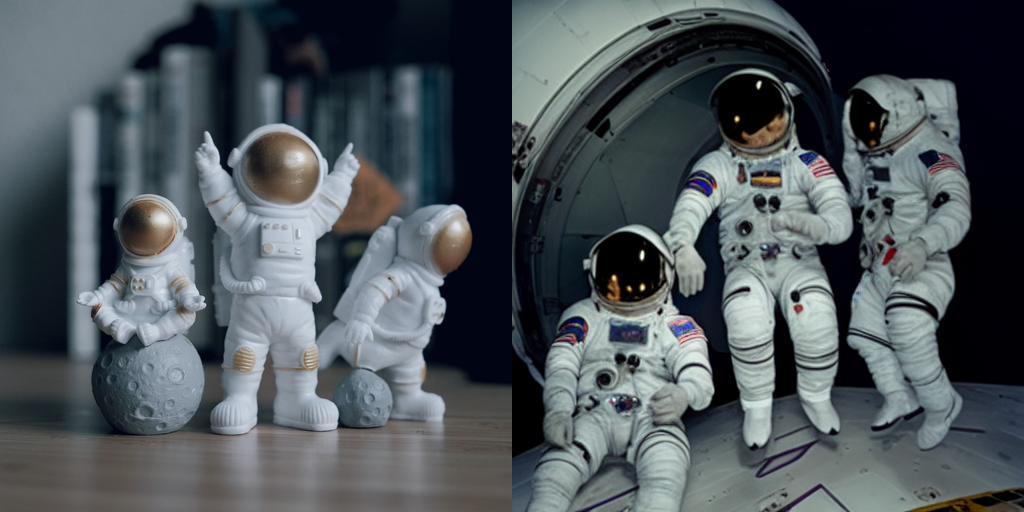

In [15]:
# @title Image2Image (Генерация изображения из другого изображения):
# @markdown <-- Начать генерацию

# @markdown ---
# @markdown Загрузка изображения начнётся после запуска этого блока.

# @markdown ---
# @markdown Сила:

# @markdown Чем ниже значене, тем ближе генерация будет к изображению, которое вы загрузили. Чем больше значение, тем сильнее нейросеть будет креативничать.

img2img_strength = 0.1 # @param {type:"slider", min:0.1, max:1.0, step:0.1}

# @markdown Силу нужно комбинировать с шагами. Итоговое количество шагов для генерации шума рассчитывается по формуле (Шаги * Сила).

# @markdown Шаги:
steps = 50 # @param {type:"number"}
# @markdown ---
# @markdown Показывать диффузию в реальном времени?
show_diffusion = True # @param {type:"boolean"}
# @markdown ---
print("Выберите исходное изображение: ")
init_image = files.upload()

if init_image:
  image_key = list(init_image.keys())[0]
  image_data = init_image[image_key]
  img = Image.open(io.BytesIO(image_data))
  img_width, img_height = img.size
  if sd_type == "Stable Diffusion 1.5/2.0":
    compel_proc = Compel(tokenizer=img2img_pipe.tokenizer, text_encoder=img2img_pipe.text_encoder)
    prompt_embeds = compel_proc(prompt)

  if sd_type == "Stable Diffusion XL (Turbo)":
    compel = Compel(
      tokenizer=[img2img_pipe.tokenizer, img2img_pipe.tokenizer_2] ,
      text_encoder=[img2img_pipe.text_encoder, img2img_pipe.text_encoder_2],
      returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
      requires_pooled=[False, True]
    )
    conditioning, pooled = compel(prompt)

  output = [
      "# Текущая модель Stable Diffusion: " + current_checkpoint,
  ]
  if use_lora:
      output.append("# Текущая модель LoRA: " + lora_path)
  output.extend([
      "# Текущий стиль: " + styles,
      "# Промпт: " + prompt,
      "# Негативный промпт: " + negs,
      "# Разрешение: " + str(img_width) + "x" + str(img_height),
      "# Сила: " + str(img2img_strength)
  ])
  max_length_string = max(output, key=len)

  print("#" * len(max_length_string) )
  for item in output:
    print(item)

  if not randomness:
    generator = torch.Generator(current_device).manual_seed(seed)
    print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * len(max_length_string)) )
  elif randomness:
    current_seed = torch.Generator(current_device).seed()
    generator = torch.Generator(current_device).manual_seed(current_seed)
    print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * len(max_length_string) ))

  if sd_type == "Stable Diffusion 1.5/2.0":
    if show_diffusion:
      result = img2img_pipe(prompt_embeds=prompt_embeds, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], image=img, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator).images[0]
    else:
      result = img2img_pipe(prompt_embeds=prompt_embeds, image=img, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator).images[0]

  if sd_type == "Stable Diffusion XL (Turbo)":
    if show_diffusion:
      result = img2img_pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], image=img, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator).images[0]
    else:
      result = img2img_pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, image=img, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator).images[0]

  clear_output()
  print("#" * len(max_length_string) )
  print("# Текущая модель Stable Diffusion: " + current_checkpoint)
  if use_lora:
    print("# Текущая модель LoRA: " + lora_path)
  print("# Текущий стиль: " + styles)
  print("# Промпт: " + prompt)
  print("# Негативный промпт: " + negs)
  print("# Разрешение: " + str(img_width) + "x" + str(img_height))
  print("# Сила: " + str(img2img_strength))
  if not randomness:
    print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * len(max_length_string) ))
  elif randomness:
    print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * len(max_length_string) ))

  if use_gdrive:
    today = str(date.today())
    if not os.path.exists("/content/gdrive/MyDrive/SDOutput/" + today):
      os.makedirs("/content/gdrive/MyDrive/SDOutput/" + today, exist_ok=True)
    time = datetime.now()
    time = str(time.strftime("%H-%M-%S"))
    file_name = time + "_" + "seed_" + str(current_seed) + "_image" + "_img2imged.png"
    file_name = "/content/gdrive/MyDrive/SDOutput/" + today + "/" + file_name
    result.save(file_name)
    print("Сохранено: " + file_name)

  display( make_image_grid([img, result], rows=1, cols=2) )
else:
  print("Вы отменили загрузку изображения :(")

########################################
# Текущая модель Stable Diffusion: 
# Текущий стиль: Без стиля
# Промпт: skull++++ mask, morbid, horror
# Негативный промпт: 
# Разрешение изображения: 512x512
# Разрешение маски: 512x512
# Сила: 0.5
# Seed этой генерации: 1994350257325217
########################################


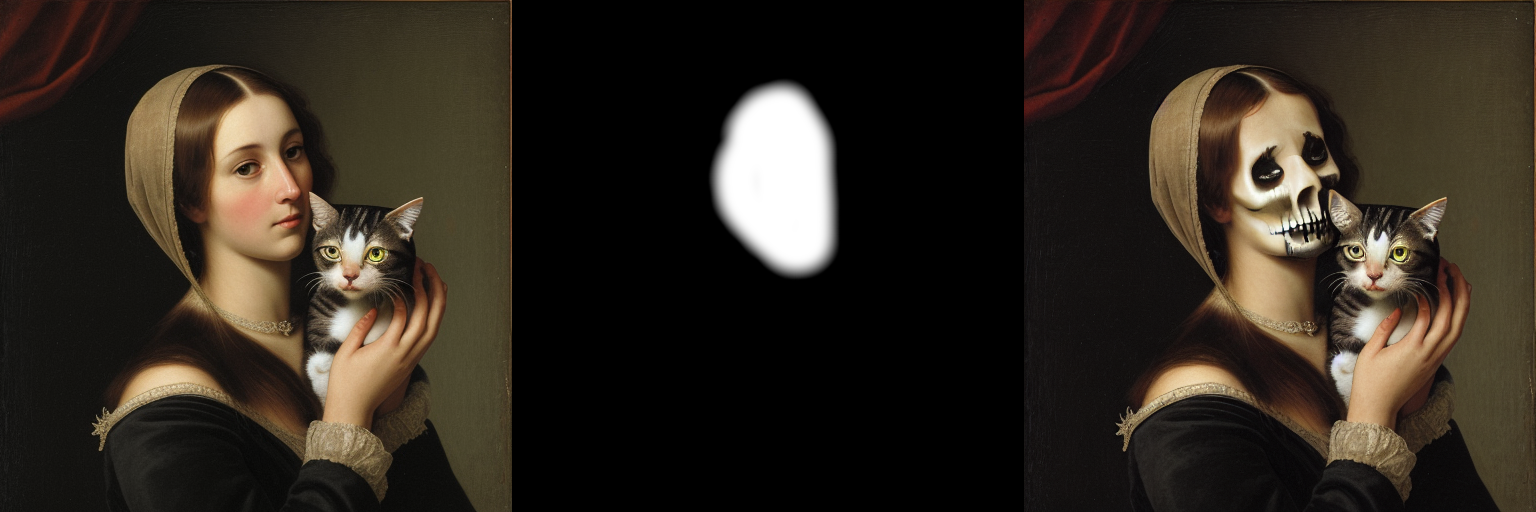

In [26]:
# @title Inpainting (Генерация изображения из другого изображения с использованием маски):
# @markdown <-- Начать генерацию

# @markdown ---
# @markdown Загрузка изображений начнётся после запуска этого блока.

# @markdown ---
# @markdown Сила:

# @markdown Чем ниже значене, тем ближе генерация будет к изображению, которое вы загрузили. Чем больше значение, тем сильнее нейросеть будет креативничать.

inpaint_strength = 0.5 # @param {type:"slider", min:0.1, max:1.0, step:0.1}

# @markdown Силу нужно комбинировать с шагами. Итоговое количество шагов для генерации шума рассчитывается по формуле (Шаги * Сила).

# @markdown Шаги:
steps = 50 # @param {type:"number"}
# @markdown ---
# @markdown Показывать диффузию в реальном времени?
show_diffusion = True # @param {type:"boolean"}
# @markdown ---
# @markdown При рисовании маски помните, что чёрные области игнорируются нейросетью, а белые - нет. Размытия белых областей в масках тоже поддерживаются.
print("Выберите исходное изображение: ")
inpaint_image = files.upload()
print("Выберите изображение маски: ")
inpaint_mask =  files.upload()

if inpaint_image and inpaint_mask:
  inpaint_image_key = list(inpaint_image.keys())[0]
  inpaint_mask_image_key = list(inpaint_mask.keys())[0]
  inpaint_image_data = inpaint_image[inpaint_image_key]
  inpaint_mask_image_data = inpaint_mask[inpaint_mask_image_key]
  inpaint_image = Image.open(io.BytesIO(inpaint_image_data))
  inpaint_mask_image = Image.open(io.BytesIO(inpaint_mask_image_data))
  inpaint_image_width, inpaint_image_height = inpaint_image.size
  inpaint_image_mask_width, inpaint_image_mask_height = inpaint_mask_image.size

  if sd_type == "Stable Diffusion 1.5/2.0":
    compel_proc = Compel(tokenizer=inpaint_pipe.tokenizer, text_encoder=inpaint_pipe.text_encoder)
    prompt_embeds = compel_proc(prompt)

  if sd_type == "Stable Diffusion XL (Turbo)":
    compel = Compel(
      tokenizer=[inpaint_pipe.tokenizer, inpaint_pipe.tokenizer_2] ,
      text_encoder=[inpaint_pipe.text_encoder, inpaint_pipe.text_encoder_2],
      returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
      requires_pooled=[False, True]
    )
    conditioning, pooled = compel(prompt)

  output = [
      "# Текущая модель Stable Diffusion: " + current_checkpoint,
  ]
  if use_lora:
      output.append("# Текущая модель LoRA: " + lora_path)
  output.extend([
      "# Текущий стиль: " + styles,
      "# Промпт: " + prompt,
      "# Негативный промпт: " + negs,
      "# Разрешение изображения: " + str(inpaint_image_width) + "x" + str(inpaint_image_height),
      "# Разрешение маски: " + str(inpaint_image_mask_width) + "x" + str(inpaint_image_mask_height),
      "# Сила: " + str(img2img_strength)
  ])
  max_length_string = max(output, key=len)

  print("#" * len(max_length_string) )
  for item in output:
    print(item)

  if not randomness:
    generator = torch.Generator(current_device).manual_seed(seed)
    print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * len(max_length_string)) )
  elif randomness:
    current_seed = torch.Generator(current_device).seed()
    generator = torch.Generator(current_device).manual_seed(current_seed)
    print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * len(max_length_string) ))

  if sd_type == "Stable Diffusion 1.5/2.0":
    if show_diffusion:
      result = inpaint_pipe(prompt_embeds=prompt_embeds, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], image=inpaint_image, mask_image=inpaint_mask_image, strength = inpaint_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator).images[0]
    else:
      result = inpaint_pipe(prompt_embeds=prompt_embeds, image=inpaint_image, mask_image=inpaint_mask_image, strength = inpaint_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator).images[0]

  if sd_type == "Stable Diffusion XL (Turbo)":
    if show_diffusion:
      result = inpaint_pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], image=inpaint_image, mask_image=inpaint_mask_image, strength = inpaint_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator).images[0]
    else:
      result = inpaint_pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, image=inpaint_image, mask_image=inpaint_mask_image, strength = inpaint_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator).images[0]

  clear_output()
  print("#" * len(max_length_string) )
  print("# Текущая модель Stable Diffusion: " + current_checkpoint)
  if use_lora:
    print("# Текущая модель LoRA: " + lora_path)
  print("# Текущий стиль: " + styles)
  print("# Промпт: " + prompt)
  print("# Негативный промпт: " + negs)
  print("# Разрешение изображения: " + str(inpaint_image_width) + "x" + str(inpaint_image_height) )
  print("# Разрешение маски: " + str(inpaint_image_mask_width) + "x" + str(inpaint_image_mask_height) )
  print("# Сила: " + str(inpaint_strength))
  if not randomness:
    print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * len(max_length_string) ))
  elif randomness:
    print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * len(max_length_string) ))

  if use_gdrive:
    today = str(date.today())
    if not os.path.exists("/content/gdrive/MyDrive/SDOutput/" + today):
      os.makedirs("/content/gdrive/MyDrive/SDOutput/" + today, exist_ok=True)
    time = datetime.now()
    time = str(time.strftime("%H-%M-%S"))
    file_name = time + "_" + "seed_" + str(current_seed) + "_image" + "_inpainted.png"
    file_name = "/content/gdrive/MyDrive/SDOutput/" + today + "/" + file_name
    result.save(file_name)
    print("Сохранено: " + file_name)

  display( make_image_grid([inpaint_image, inpaint_mask_image, result], rows=1, cols=3) )
else:
  print("Вы отменили загрузку изображения :(")